In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/PySpark_Config')

Setup PySpark in Google Colab

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-3.0.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

Configuration & Testing

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/MyDrive/PySpark_Config/spark-3.0.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
findspark.find()

'/content/drive/MyDrive/PySpark_Config/spark-3.0.1-bin-hadoop2.7'

In [ ]:
#spark.stop()

In [ ]:
from pyspark.sql import SparkSession
import pyspark
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '5g'), ('spark.cores.max', '3'), ('spark.driver.memory','5g'), ('spark.ui.port', '4050'),
                                   ("spark.sql.autoBroadcastJoinThreshold", "-1"),
                                   ("ConcGCThreads", "20"), ("InitiatingHeapOcuupancyPercent", "35"),
                                   ("spark.storage.memoryFraction","0.4"), ("spark.shuffle.memoryFraction", "0.2"),
                                   ("spark.executor.extraJavaOptions", "-XX:-UseGCOverheadLimit")])
#spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config(conf=conf)\
        .getOrCreate()
        #.config('spark.ui.port', '4050')\
        
        

spark.sparkContext._conf.getAll()


IndentationError: ignored

In [ ]:
# This is for Spark UI
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip
# get_ipython().system_raw('./ngrok http 4050 &')
# !curl -s http://localhost:4040/api/tunnels

Input Image Data using Python

In [ ]:
import cv2
from os import listdir
from PIL import Image as PImage
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
image_num = 100
factor = 2
def loadImages(path,image_num):
    # return array of images
    imagesList = listdir(path)
    loadedImages = []
    count=0
    for image in imagesList[0:min(len(imagesList),image_num)]:
      img = PImage.open(path +'/'+ image)
      if count == 0:
        print(img.size)
      img = img.resize((int(img.size[1]/factor), int(img.size[0]/factor)))
      #img.thumbnail(maxsize)
      img = np.array(img)
      if count == 0:
        print(img.shape)
      img = img.reshape(img.shape[0]*img.shape[1])
      loadedImages.append(img)
      count = count + 1

    return loadedImages


path = "/content/drive/MyDrive/Pixxel_Work"

# your images in an array
imgs = loadImages(path, image_num)

(1191, 3441)
(595, 1720)


In [ ]:
sum=0
print(len(imgs[0]))
for i in range(len(imgs[0])):
  sum=sum+imgs[0][i]
print(sum)

1023400
243028554


In [ ]:
# Define schema of pyspark dataframe
row_num = len(imgs)
col_num = len(imgs[0])
imgs_np = np.array(imgs)

In [ ]:
print(imgs_np.shape)
print(imgs_np)

(100, 1023400)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# Perform PCA
from sklearn.decomposition import PCA
variance = 0.98
pca = PCA(variance)
pca.fit(imgs_np)
print("Number of components after PCA 0.98 = " + str(pca.n_components_))

# Transform dataframe as per PCA
pca_data = pca.transform(imgs_np)
print("Dimension of our data after PCA = " + str(pca_data.shape))

Number of components after PCA 0.98 = 2
Dimension of our data after PCA = (100, 2)


In [ ]:
pca_df = pd.DataFrame(pca_data)
print(pca_df.shape)

(100, 2)


In [ ]:
# Running K means cluster
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pca_df)
    distortions.append(kmeanModel.inertia_)


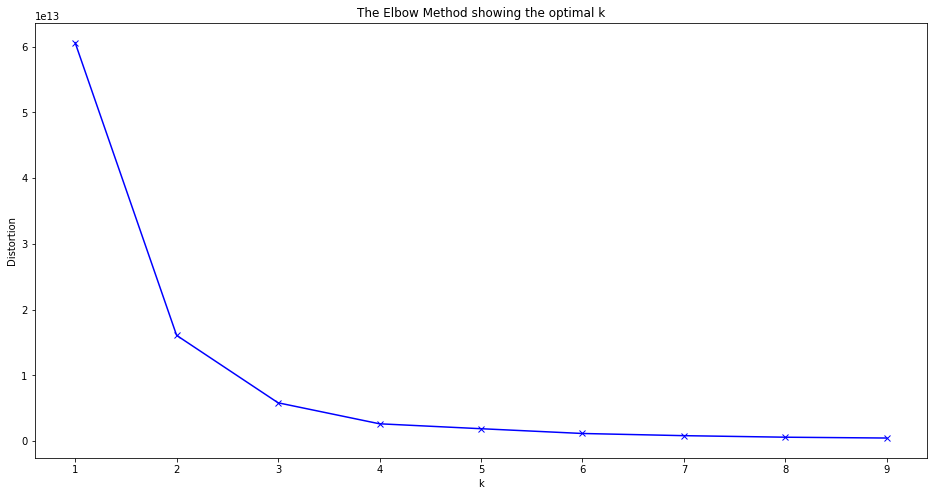

In [ ]:
# Plot PCA graph
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

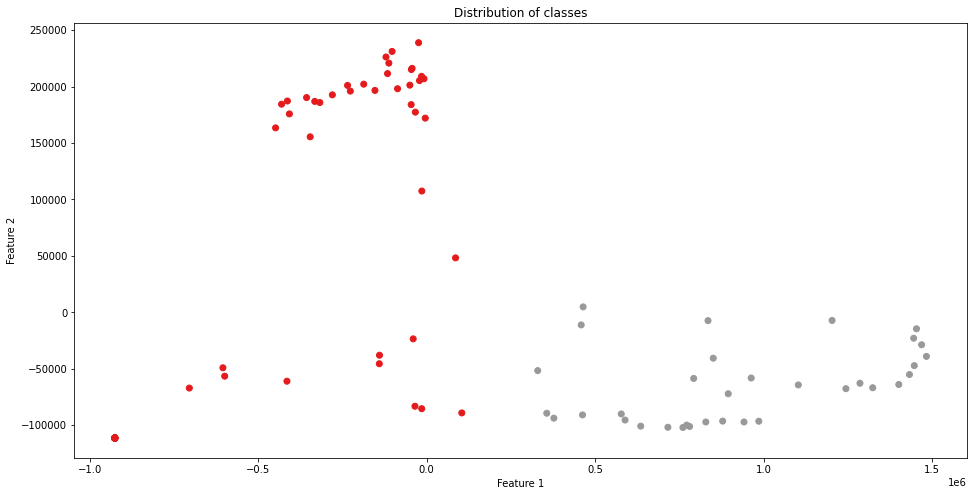

In [ ]:
# Final Clustering
kmeanModel = KMeans(n_clusters=2)
kmeanModel.fit(pca_df)

# Plot clustering
pca_df['k_means']=kmeanModel.predict(pca_df)
plt.figure(figsize=(16,8))
plt.scatter(pca_df[0], pca_df[1], c=pca_df['k_means'],cmap=plt.cm.Set1)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Distribution of classes')
plt.show()

# **Running Code for 110Kt dataset**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/')

import cv2
from os import listdir
from PIL import Image as PImage
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA


def loadImages(path,image_num):
    # return array of images
    imagesList = listdir(path)
    loadedImages = []
    count=0
    for image in imagesList[0:min(len(imagesList),image_num)]:
      img = PImage.open(path +'/'+ image)
      if count == 0:
        print(img.size)
      img = img.resize((int(img.size[1]/factor), int(img.size[0]/factor)))
      #img.thumbnail(maxsize)
      img = np.array(img)
      if count == 0:
        print(img.shape)
      img = img.reshape(img.shape[0]*img.shape[1])
      loadedImages.append(img)
      count = count + 1

    return loadedImages


image_num = 100
factor = 2
path = "/content/drive/MyDrive/Pixxel_Work/110Kt_images/"

# your images in an array
imgs = loadImages(path, image_num)

# Test the output
sum=0
print(len(imgs[0]))
for i in range(len(imgs[0])):
  sum=sum+imgs[0][i]
print(sum)

# Create numpy array 
imgs_np = np.array(imgs)
print(imgs_np.shape)
print(imgs_np)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1061, 3521)
(530, 1760)
932800
316262
(100, 932800)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
# Perform PCA
from sklearn.decomposition import PCA
variance = 0.98
pca = PCA(variance)
pca.fit(imgs_np)
print("Number of components after PCA 0.98 = " + str(pca.n_components_))

# Transform dataframe as per PCA
pca_data = pca.transform(imgs_np)
print("Dimension of our data after PCA = " + str(pca_data.shape))

pca_df = pd.DataFrame(pca_data)
print(pca_df.shape)

Number of components after PCA 0.98 = 1
Dimension of our data after PCA = (100, 1)
(100, 1)


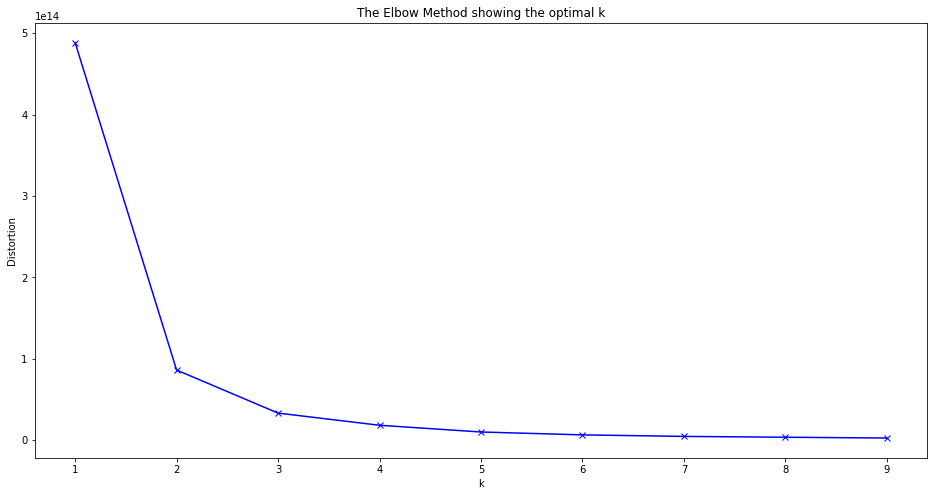

In [8]:
# Running K means cluster
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pca_df)
    distortions.append(kmeanModel.inertia_)

# Plot PCA graph
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# Final Clustering
kmeanModel = KMeans(n_clusters=2)
kmeanModel.fit(pca_df)

print(pca_df.head(5))
# Plot clustering
pca_df['k_means']=kmeanModel.predict(pca_df)
plt.figure(figsize=(16,8))
plt.scatter(pca_df[0], c=pca_df['k_means'])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Distribution of classes')
plt.show()

# Running Code for 110PZ dataset

In [12]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/')

import cv2
from os import listdir
from PIL import Image as PImage
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA


def loadImages(path,image_num):
    # return array of images
    imagesList = listdir(path)
    loadedImages = []
    count=0
    for image in imagesList[0:min(len(imagesList),image_num)]:
      img = PImage.open(path +'/'+ image)
      if count == 0:
        print(img.size)
      img = img.resize((int(img.size[1]/factor), int(img.size[0]/factor)))
      #img.thumbnail(maxsize)
      img = np.array(img)
      if count == 0:
        print(img.shape)
      img = img.reshape(img.shape[0]*img.shape[1])
      loadedImages.append(img)
      count = count + 1

    return loadedImages


image_num = 100
factor = 2
path = "/content/drive/MyDrive/Pixxel_Work/110Kt_images/"

# your images in an array
imgs = loadImages(path, image_num)

# Test the output
sum=0
print(len(imgs[0]))
for i in range(len(imgs[0])):
  sum=sum+imgs[0][i]
print(sum)

# Create numpy array 
imgs_np = np.array(imgs)
print(imgs_np.shape)
print(imgs_np)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1061, 3521)
(530, 1760)
932800
316262
(100, 932800)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [13]:
# Perform PCA
from sklearn.decomposition import PCA
variance = 0.98
pca = PCA(variance)
pca.fit(imgs_np)
print("Number of components after PCA 0.98 = " + str(pca.n_components_))

# Transform dataframe as per PCA
pca_data = pca.transform(imgs_np)
print("Dimension of our data after PCA = " + str(pca_data.shape))

pca_df = pd.DataFrame(pca_data)
print(pca_df.shape)

Number of components after PCA 0.98 = 1
Dimension of our data after PCA = (100, 1)
(100, 1)


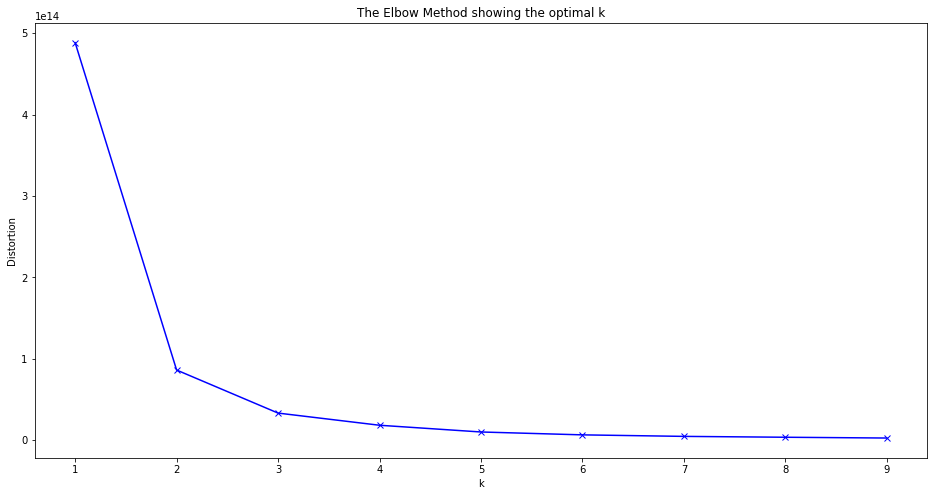

In [14]:
# Running K means cluster
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pca_df)
    distortions.append(kmeanModel.inertia_)

# Plot PCA graph
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# Final Clustering
kmeanModel = KMeans(n_clusters=2)
kmeanModel.fit(pca_df)

# Plot clustering
pca_df['k_means']=kmeanModel.predict(pca_df)
plt.figure(figsize=(16,8))
plt.scatter(pca_df[0], pca_df[1], c=pca_df['k_means'],cmap=plt.cm.Set1)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Distribution of classes')
plt.show()

In [ ]:
#df = pd.DataFrame(imgs_np)
#rdd = spark.sparkContext.parallelize(imgs_np)

In [ ]:
#spark_df = spark.createDataFrame(df)